In [2]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
import scipy.io as sio
from scipy.stats import norm, gamma
import pandas as pd
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

## Load Data from Precip and ENSO Indices

In [4]:
# load precip data
fpath = './'
file_precip = 'precip.V1.0.mon.mean2018.nc'
ds_precip = xr.open_dataset(fpath + file_precip).sel(time=slice('1950','2016')) # skip 1948 and 1949 due to weak data
ds_precip

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 804)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2016-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 05/2012 by CAS from data obtained at NOAA NCEP/CPC
    description:    CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.unified.da...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...

In [5]:
ds_precip.isel(time=0).precip.time

<xarray.DataArray 'time' ()>
array('1950-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1950-01-01
Attributes:
    long_name:     Time
    delta_t:       0000-01-00 00:00:00
    avg_period:    0000-01-00 00:00:00
    actual_range:  [2173896. 2783112.]

In [6]:
# load el nino index data
file_enso = 'Nino_3-4.mat'
mat_enso = sio.loadmat(fpath + file_enso)
mat_enso

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jan 15 17:49:33 2018',
 '__version__': '1.0',
 '__globals__': [],
 'anom34': array([[-0.81],
        [-0.09],
        [ 0.88],
        [ 0.51],
        [-0.46],
        [-0.34],
        [ 0.31],
        [ 0.48],
        [ 0.47],
        [ 0.73],
        [ 0.39],
        [ 0.25],
        [ 0.15],
        [ 0.25],
        [ 0.19],
        [ 0.13],
        [-0.52],
        [-0.1 ],
        [ 0.34],
        [ 0.54],
        [ 0.45],
        [ 0.72],
        [ 0.77],
        [ 0.5 ],
        [ 0.09],
        [ 0.02],
        [ 0.12],
        [-0.23],
        [-0.44],
        [-0.51],
        [-0.26],
        [-0.01],
        [-0.41],
        [-0.01],
        [-0.56],
        [ 0.07],
        [ 0.32],
        [ 0.34],
        [ 0.53],
        [ 0.19],
        [ 0.04],
        [ 0.02],
        [-0.06],
        [ 0.03],
        [ 0.61],
        [ 0.13],
        [ 0.08],
        [ 0.1 ],
        [-0.3 ],
        [-0.2 ],
 

In [7]:
del mat_enso['__header__']
del mat_enso['__version__']
del mat_enso['__globals__']

In [8]:
mat_enso.keys()

dict_keys(['anom34', 'nino3', 'nino34', 'nino4', 'year'])

In [9]:
# pull out arrays to eventually construct xarray dataset 
anom34 = np.array(mat_enso['anom34']).squeeze()
nino3 = np.array(mat_enso['nino3']).squeeze()
nino34 = np.array(mat_enso['nino34']).squeeze()
nino4 = np.array(mat_enso['nino4']).squeeze()
year = np.array(mat_enso['year']).squeeze()

# select only 804 months from 1950-01 to 2016-12 to match with precip data set
anom34 = anom34[0:len(anom34)-12]
nino3 = nino3[0:len(nino3)-12]
nino34 = nino34[0:len(nino34)-12]
nino4 = nino4[0:len(nino4)-12]
year = year[0:len(year)-12]

print(len(ds_precip.precip))
print(len(anom34), len(nino3), len(nino34), len(year))

804
804 804 804 804


In [10]:
# convert years to datetime object in enso index
time = np.zeros(len(year)).astype(str) # initialize empty array for dates
yeartemp = year-0.00001 # quick fix to get 12 data points per year

for i,yr in enumerate(yeartemp):
    Y = np.floor(yr).astype(int).astype(str)
    m = np.round((yr - np.floor(yr))*12,0).astype(int).astype(str)
    if len(m) < 2:
        m = '0' + m
    time[i] = Y + '-' + m + '-01' # artificially moves january
    
time

array(['1950-01-01', '1950-02-01', '1950-03-01', '1950-04-01',
       '1950-05-01', '1950-06-01', '1950-07-01', '1950-08-01',
       '1950-09-01', '1950-10-01', '1950-11-01', '1950-12-01',
       '1951-01-01', '1951-02-01', '1951-03-01', '1951-04-01',
       '1951-05-01', '1951-06-01', '1951-07-01', '1951-08-01',
       '1951-09-01', '1951-10-01', '1951-11-01', '1951-12-01',
       '1952-01-01', '1952-02-01', '1952-03-01', '1952-04-01',
       '1952-05-01', '1952-06-01', '1952-07-01', '1952-08-01',
       '1952-09-01', '1952-10-01', '1952-11-01', '1952-12-01',
       '1953-01-01', '1953-02-01', '1953-03-01', '1953-04-01',
       '1953-05-01', '1953-06-01', '1953-07-01', '1953-08-01',
       '1953-09-01', '1953-10-01', '1953-11-01', '1953-12-01',
       '1954-01-01', '1954-02-01', '1954-03-01', '1954-04-01',
       '1954-05-01', '1954-06-01', '1954-07-01', '1954-08-01',
       '1954-09-01', '1954-10-01', '1954-11-01', '1954-12-01',
       '1955-01-01', '1955-02-01', '1955-03-01', '1955-

In [11]:
np.datetime64(time[-1].astype(str),format='%Y.%m')

numpy.datetime64('2016-12-01')

In [12]:
mat_enso

{'anom34': array([[-0.81],
        [-0.09],
        [ 0.88],
        [ 0.51],
        [-0.46],
        [-0.34],
        [ 0.31],
        [ 0.48],
        [ 0.47],
        [ 0.73],
        [ 0.39],
        [ 0.25],
        [ 0.15],
        [ 0.25],
        [ 0.19],
        [ 0.13],
        [-0.52],
        [-0.1 ],
        [ 0.34],
        [ 0.54],
        [ 0.45],
        [ 0.72],
        [ 0.77],
        [ 0.5 ],
        [ 0.09],
        [ 0.02],
        [ 0.12],
        [-0.23],
        [-0.44],
        [-0.51],
        [-0.26],
        [-0.01],
        [-0.41],
        [-0.01],
        [-0.56],
        [ 0.07],
        [ 0.32],
        [ 0.34],
        [ 0.53],
        [ 0.19],
        [ 0.04],
        [ 0.02],
        [-0.06],
        [ 0.03],
        [ 0.61],
        [ 0.13],
        [ 0.08],
        [ 0.1 ],
        [-0.3 ],
        [-0.2 ],
        [-0.37],
        [-1.34],
        [-1.  ],
        [-0.84],
        [-0.42],
        [-0.52],
        [-0.59],
        [-0.27],
    

In [13]:
## Create xarray for ENSO
data_vars = {'nino3': (['time'],nino3), 'nino4':(['time'],nino4), 'nino34':(['time'],nino34), 'anom34':(['time'],anom34)}
coords_time = {'time':time}
ds_enso = xr.Dataset(data_vars, coords=coords_time)
ds_enso

<xarray.Dataset>
Dimensions:  (time: 804)
Coordinates:
  * time     (time) <U32 '1950-01-01' '1950-02-01' ... '2016-11-01' '2016-12-01'
Data variables:
    nino3    (time) float64 -2.11 -1.52 -0.8 -1.04 ... -0.29 -0.54 -0.55 -0.44
    nino4    (time) float64 -1.3 -1.43 -1.68 -1.55 ... -0.14 -0.32 -0.32 -0.09
    nino34   (time) float64 -2.0 -1.68 -1.37 -1.43 ... -0.58 -0.69 -0.68 -0.47
    anom34   (time) float64 -0.81 -0.09 0.88 0.51 ... -0.15 -0.22 -0.23 -0.35

In [14]:
ds_precip

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 804)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2016-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 05/2012 by CAS from data obtained at NOAA NCEP/CPC
    description:    CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.unified.da...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...

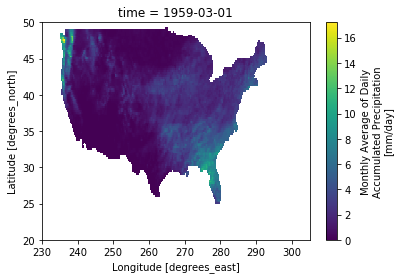

In [15]:
ds_precip.precip.isel(time=110).plot()

In [16]:
xr.DataArray(arr_precip).isel(dim_2=110).plot()

NameError: name 'arr_precip' is not defined

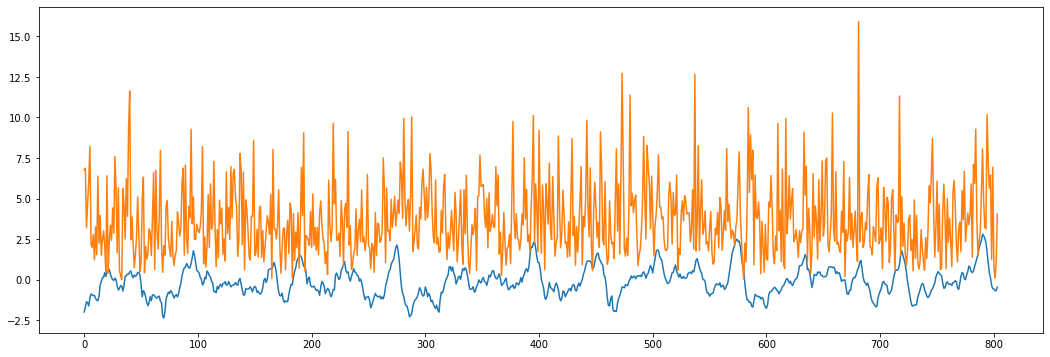

In [17]:
fig = plt.subplots(figsize=(18,6))
plt.plot(ds_enso.nino34)
plt.plot(ds_precip.precip.sel(lon=266.125,lat=31.125))

In [18]:
## setting up critical values and d.f. for significance testing
yrmx = int(len(ds_enso.time)/12) # number of years for d.f. determination; 1950 to 2016
print(yrmx)
alphaupper = 1-0.05/2 # 95% confidence level
tcrit = stats.t.ppf(alphaupper,yrmx) # critical value for two tailed test with d.f.
print(alphaupper, tcrit)

67
0.975 1.9960083534755055


In [19]:
ds_precip.precip

<xarray.DataArray 'precip' (time: 804, lat: 120, lon: 300)>
[28944000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2016-12-01
Attributes:
    long_name:     Monthly Average of Daily Accumulated Precipitation
    units:         mm/day
    precision:     2
    var_desc:      Precipitation
    dataset:       CPC Unified Gauge-Based Analysis of Daily Precipitation ov...
    level_desc:    Surface
    statistic:     Monthly Mean
    parent_stat:   Observation
    valid_range:   [  0. 350.]
    actual_range:  [ 0.       63.015995]

In [20]:
# compute monthly climo of precip data with std
ds_precip_m = ds_precip.groupby('time.month',squeeze=False).mean(dim='time')
ds_precip_m = ds_precip_m.rename_vars(precip='m_mean')

ds_precip_d = ds_precip.groupby('time.month',squeeze=False).std(dim='time', ddof=1) # set d.f. to N-1
ds_precip_d = ds_precip_d.rename_vars(precip='stdev')

ds_precip_m = ds_precip_m.merge(ds_precip_d)
ds_precip_m

/home/disk/atmos/vcooper/miniconda3/envs/beauchard/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/disk/atmos/vcooper/miniconda3/envs/beauchard/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, month: 12)
Coordinates:
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    m_mean   (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    stdev    (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [22]:
ds_precip_m

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, month: 12)
Coordinates:
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    m_mean   (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    stdev    (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

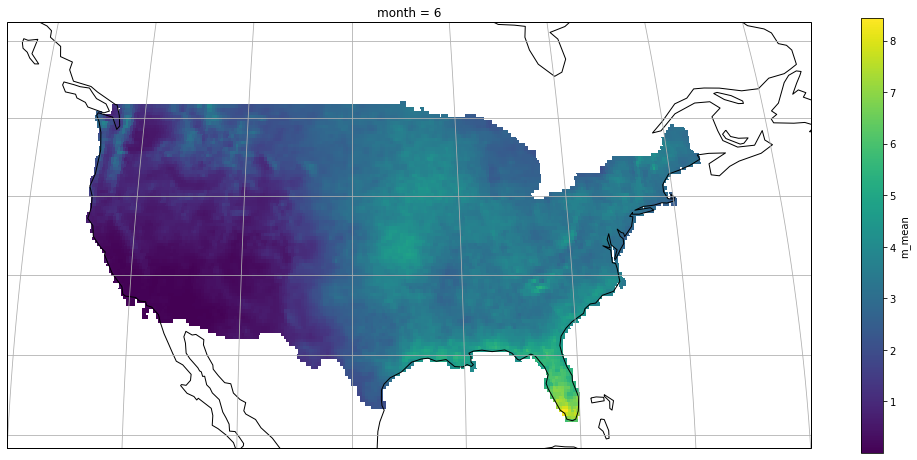

In [21]:
fig, ax = plt.subplots(figsize=(18,8))
ax = plt.axes(projection=ccrs.Robinson(260))
ax.set_extent([230,300,23,50]) # x0,x1,y0,y1
ax.coastlines()
ax.gridlines()
ds_precip_m.m_mean.isel(month=5).plot(ax=ax, transform=ccrs.PlateCarree())

In [19]:
# normalize nino3-4 data
nino34m = ds_enso.nino34.mean()
nino34std = ds_enso.nino34.std(ddof=1)
print(nino34m, nino34std)

nino34_norm = (ds_enso.nino34-nino34m)/nino34std
#nino34_norm = nino34_norm.rename_vars(nino34=nino34_norm)
#ds_enso = ds_enso.merge(nino)
nino34_norm
print(nino34_norm.mean(), nino34_norm.std(ddof=1))

<xarray.DataArray 'nino34' ()>
array(-0.128632) <xarray.DataArray 'nino34' ()>
array(0.883485)
<xarray.DataArray 'nino34' ()>
array(-4.418798e-17) <xarray.DataArray 'nino34' ()>
array(1.)


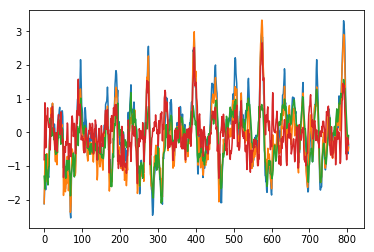

In [20]:
# plot of normalized nino 34
plt.plot(nino34_norm)
plt.plot(nino3)
plt.plot(nino4)
plt.plot(anom34)


In [21]:
# standardize monthly precip data by removing mean, divide by sd

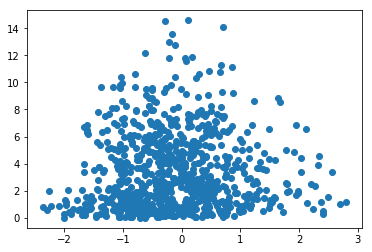

In [22]:
# test of scatter of single grid point with nino
plt.scatter(nino34,ds_precip.sel(lat=26.125,lon=279.125).precip)

In [23]:
ds_precip_m

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, month: 12)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    m_mean   (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    stdev    (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [24]:
ds_precip_norm = ds_precip
ds_precip_norm.isel(time=20).time.dt.month.values

array(9)

In [25]:
data_month = ds_precip_norm.isel(time=20).time.dt.month.values
ds_precip_m.sel(month=data_month)

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
    month    int64 9
Data variables:
    m_mean   (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    stdev    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

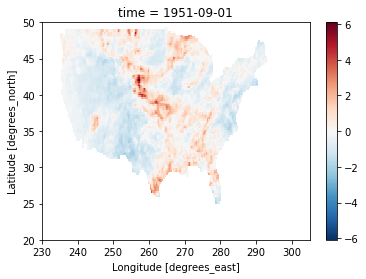

In [26]:
data_month = ds_precip_norm.isel(time=20).time.dt.month.values
#ds_precip_m.sel(month=data_month).precip
temp = (ds_precip.isel(time=20).precip - ds_precip_m.sel(month=data_month).m_mean)/ds_precip_m.isel(month=data_month).stdev
#temp.sel(lon=35,lon=260)
temp.plot()

In [187]:
ds_precip_norm.pn[:,:,0::12]

<xarray.DataArray 'pn' (lat: 120, lon: 300, time: 67)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * time     (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2016-01-01

## Normalizing Precip Data

In [28]:
## xarray issue: could not directly edit values (avoided below)

ds_precip_norm = ds_precip
#temp = xr.Dataset()
#tempm = np.zeros(len(ds_precip.time))
#tempmn = np.zeros(len(ds_precip.time))
#for i, ds in enumerate(ds_precip_norm.precip):
#    m = ds.time.dt.month.values
#    climo_mean = ds_precip_m.sel(month=m).m_mean
#    climo_stdev = ds_precip_m.sel(month=m).stdev
#    precip_norm = (ds - climo_mean)/climo_stdev
    
    # get all longitude cells at the given timestep
#    print(precip_norm.isel(lat=100,lon=160))
    
    #ds_precip_norm = ds_precip_norm.update(precip_norm)#.sel(lat=35.125,lon=264.125).values
   # ds_precip_norm.isel(time=i).precip.values = precip_norm
#    print(i, m, climo_mean.sel(lat=35.125,lon=264.125).values, climo_stdev.sel(lat=35.125,lon=264.125).values, precip_norm.sel(lat=35.125,lon=264.125).values)
#    print(ds.sel(lat=35.125,lon=264.125).values, ds_precip_norm.isel(time=i).sel(lat=35.125,lon=264.125).precip.values)

#ds_precip_norm

<xarray.DataArray 'precip' (lat: 120, lon: 300)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
    time     datetime64[ns] 1950-03-01
Attributes:
    long_name:     Monthly Average of Daily Accumulated Precipitation
    units:         mm/day
    precision:     2
    var_desc:      Precipitation
    dataset:       CPC Unified Gauge-Based Analysis of Daily Precipitation ov...
    level_desc:    Surface
    statistic:     Monthly Mean
    parent_stat:   Observation
    valid_range:   [  0. 350.]
    actual_range:  [ 0.       63.015995] 

 <xarray.DataArray (lat: 120, lon: 300)>


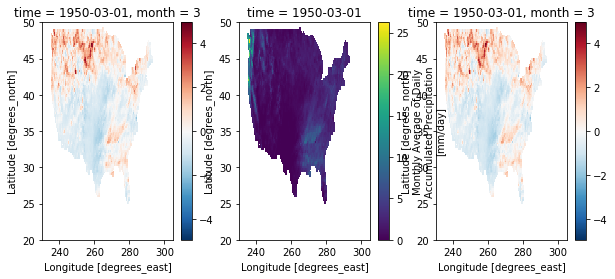

In [29]:
# this code captures problem with xarray -- couldn't edit directly
fig, ax = plt.subplots(ncols=3, figsize = (10,4))

# walk through full step
temp = ds_precip_norm.isel(time=2).precip
m = ds_precip_norm.precip.isel(time=2).time.dt.month.values.squeeze()
climo_mean = ds_precip_m.sel(month=m).m_mean
climo_stdev = ds_precip_m.sel(month=m).stdev

precip_norm = (ds_precip_norm.precip.isel(time=2) - climo_mean)/climo_stdev
precip_norm.plot(ax=ax[0])
ds_precip_norm.isel(time=2)['precip'].values = precip_norm.values
temp = precip_norm


ds_precip_norm.precip.isel(time=2).plot(ax=ax[1])
temp.plot(ax=ax[2])
print(ds_precip_norm.isel(time=2).precip,'\n\n', temp)

In [30]:
ds_precip_norm.isel(time=2)['precip'].sel(lat=35.125,lon=264.125).values# = 100.
ds_precip_norm.isel(time=2)['precip'].sel(lat=35.125,lon=264.125)

<xarray.DataArray 'precip' ()>
array(0.605789)
Coordinates:
    lat      float32 35.125
    lon      float32 264.125
    time     datetime64[ns] 1950-03-01
Attributes:
    long_name:     Monthly Average of Daily Accumulated Precipitation
    units:         mm/day
    precision:     2
    var_desc:      Precipitation
    dataset:       CPC Unified Gauge-Based Analysis of Daily Precipitation ov...
    level_desc:    Surface
    statistic:     Monthly Mean
    parent_stat:   Observation
    valid_range:   [  0. 350.]
    actual_range:  [ 0.       63.015995]

# Solution to normalizing precip data

In [1]:
## SOLUTION
# could not find a way to edit the xarray data directly
# so I pull out np array of lat x lon size at each tstep ("da")
# I normalize da values by removing the monthly mean and div by stdev
# I place the normalized values in the initialized array

# initialize np array to hold all normalized precip data and original data
arr_precip_norm = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*len(ds_precip.precip))
arr_precip_norm = arr_precip_norm.reshape(len(ds_precip.lat),len(ds_precip.lon),len(ds_precip.precip))
arr_precip = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*len(ds_precip.precip)) # will be used later
arr_precip = arr_precip.reshape(len(ds_precip.lat),len(ds_precip.lon),len(ds_precip.precip)) # for regression

for j, da in enumerate(ds_precip.precip): # iterates over all 804 months
    m = da.time.dt.month.values
    climo_mean = ds_precip_m.sel(month=m).m_mean
    climo_stdev = ds_precip_m.sel(month=m).stdev
    arr_precip_norm[:,:,j] = (da.values - climo_mean)/climo_stdev # this array holds all normalized data
    arr_precip[:,:,j] = da.values - climo_mean # only removes mean for covariance calc later in regression
    
# also organize data by month to check means
arr_precip_norm_monthly = arr_precip_norm.reshape(len(ds_precip.lat),len(ds_precip.lon),yrmx,12,order='C')
arr_precip_monthly = arr_precip.reshape(len(ds_precip.lat),len(ds_precip.lon),yrmx,12,order='C')

# create xarray dataset from normalized data
lon = ds_precip.lon # get coords
lat = ds_precip.lat # get coords
t = ds_precip.time # get coords

ds_precip_norm = xr.Dataset({'pn': (['lat','lon','time'], arr_precip_norm)},
                    coords={'lat':lat, 'lon':lon, 'time':t})
ds_precip_norm

NameError: name 'np' is not defined

In [93]:
# confirms normalized data has monthly mean of zero at given grid point
print(arr_precip_norm_monthly[40,120,:,10].mean())
print(arr_precip_norm_monthly[45,120,:,0].mean())
print(arr_precip_norm_monthly[32,121,:,4].mean())

print(ds_precip_norm.pn.groupby('time.month').mean(dim='time').isel(lat=35,lon=120))
print(ds_precip_norm.pn.groupby('time.month').std(dim='time', ddof=1).isel(lat=35,lon=120))

7.831449828930755e-08
3.165801736845899e-08
2.0836952573327875e-07


/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190723/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'pn' (month: 12)>
array([-9.913720e-08,  3.258239e-08,  1.479969e-07, -2.766445e-07,
       -1.735735e-07, -1.324702e-07,  4.862338e-08, -1.716692e-09,
        8.095556e-08,  6.462267e-08,  9.493930e-08,  4.567651e-08])
Coordinates:
    lat      float32 28.875
    lon      float32 260.125
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
<xarray.DataArray 'pn' (month: 12)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Coordinates:
    lat      float32 28.875
    lon      float32 260.125
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12


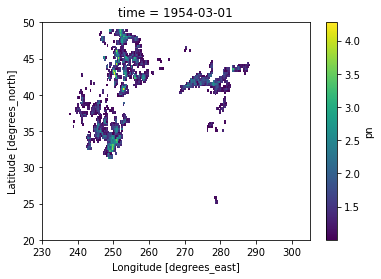

In [33]:
# sidenote testing the where selection
da_precip = ds_precip_norm.pn.isel(time=50)
da_precip.where(da_precip > 1).plot()


In [34]:
# more checking for mean methods
print(ds_precip.sel(lat=35.125,lon=264.125).groupby('time.month').mean().values)
print(ds_precip_m.m_mean.sel(lat=35.125,lon=264.125).values)

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
    lat      float32 35.125
    lon      float32 264.125
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (month) float32 1.543979 1.9595815 2.9569516 ... 2.782155 2.1257584>
[1.5439788 1.9595815 2.9569516 3.6028922 4.8003387 3.7330484 2.8678293
 2.3089135 3.7634308 3.162938  2.7821546 2.1257586]


/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190723/lib/python3.6/site-packages/xarray/core/groupby.py:833: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


## Calculate correlation for Nino3.4 and Norm Precip

In [35]:
ds_enso.nino34[12]

<xarray.DataArray 'nino34' ()>
array(-1.31)
Coordinates:
    time     <U32 '1951-01-01'

In [36]:
# reshaping normalized nino34 for regression
nino34_norm_m = nino34_norm.values.reshape(12,yrmx)
nino34_norm_m.shape

(12, 67)

## Correlation, Regression, and Significance

In [96]:
# correlation coefficients
## we can just calculate the covariance of normalized variables to get correlation
## r = cov(x,y)/(sd(x)*sd(y)) but the sd is 1 for both in our case of normalized vars

# initialize arrays to hold correlation, regression, t-stat data
# reshaping but keeping lats and lons in one dimension for loop
corr34 = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*12)
corr34 = corr34.reshape(len(ds_precip.lat)*len(ds_precip.lon),12)
reg34 = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*12)
reg34 = reg34.reshape(len(ds_precip.lat)*len(ds_precip.lon),12)
tstat34 = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*12)
tstat34 = tstat34.reshape(len(ds_precip.lat)*len(ds_precip.lon),12)

# making lat lon precip into two dimensions for the loop
arr_pn_adj_m = arr_precip_norm_monthly.reshape(
    len(ds_precip.lat)*len(ds_precip.lon),12,yrmx) # norm precip
arr_precip_m = arr_precip_monthly.reshape(
    len(ds_precip.lat)*len(ds_precip.lon),12,yrmx) # original precip

for i,nino in enumerate(nino34_norm_m):
    corr34[:,i] = np.matmul(arr_pn_adj_m[:,i,:],nino)/yrmx # corr equals cov
    reg34[:,i] = np.matmul(arr_precip_m[:,i,:],nino)/yrmx # nino x var is standardized, but precip retains units
    #reg34[:,i] = corr34[:,i]* ## also should be able to replicate with b=r*sd(y)/sd(x)
    tstat34[:,i] = corr34[:,i]*np.sqrt((yrmx-2)/(1.0-(corr34[:,i]**2))) # why did Dennis do sqrt 64 for N-2?
    print(np.shape(nino),np.shape(arr_pn_adj_m[:,i,:]))
    
corr34da = xr.DataArray(corr34.reshape(len(ds_precip.lat),len(ds_precip.lon),12,order="C"))
reg34da = xr.DataArray(reg34.reshape(len(ds_precip.lat),len(ds_precip.lon),12,order="C"))
tstat34da = xr.DataArray(tstat34.reshape(len(ds_precip.lat),len(ds_precip.lon),12,order="C"))

(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)
(67,) (36000, 67)


## COME BACK TO T STAT STIPPLING

<xarray.DataArray (dim_2: 12)>
array([     nan,      nan,      nan,      nan, 3.386361,      nan,      nan,
            nan,      nan,      nan,      nan,      nan])
Dimensions without coordinates: dim_2


<xarray.DataArray (dim_2: 12)>
array([nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan, nan])
Dimensions without coordinates: dim_2

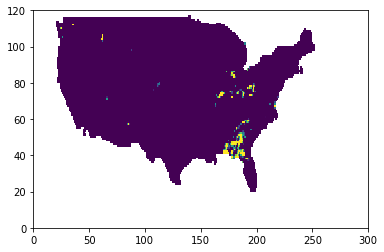

In [97]:
## Create binary variable for significance -- try with single grid cell
tstat34sig = abs(tstat34da)

plt.pcolormesh(abs(tstat34da[:,:,0]),vmin=tcrit,vmax=3)
#tstat34da[50,75,:].where(abs(tstat34da[50,75,:])>tcrit)
print(tstat34sig[50,75,:].where(tstat34sig[50,75,:]>tcrit))
tstat34sig[50,75,:] = tstat34sig[50,75,:].where(tstat34sig[50,75,:]>tcrit)
#tstat34sig[50,75,:] = np.minimum(tstat34sig[50,75,:],1)
tstat34sig[50,75,:][tstat34sig[50,75,:] > 1] = 1
tstat34sig[50,75,:]

In [39]:
## Create binary variable for significance -- full plot
tstat34sig = abs(tstat34da) # two sided test so only need magnitude of t stat
tstat34sig = tstat34sig.where(tstat34sig>tcrit) # only keeps values greater than tstat -- others are nan
#tstat34sig[tstat34sig > 1] = 1 # sets all significant values to 1
#tstat34sig[:,:,0].plot()
levels = 1 # [0,tcrit-0.0001,1000]
#plt.contourf(tstat34sig.dim_1,tstat34sig.dim_0,tstat34sig[:,:,0], levels=levels, hatches=["","."])

In [40]:
tstat34sig

<xarray.DataArray (dim_0: 120, dim_1: 300, dim_2: 12)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

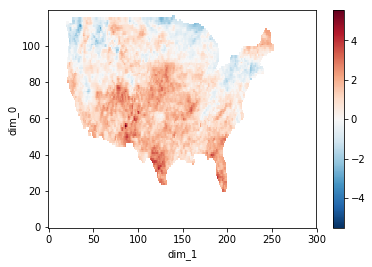

In [41]:
tstat34da[:,:,1].plot()

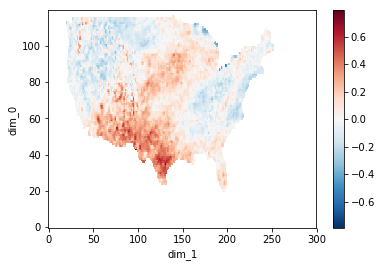

In [42]:
corr34da[:,:,7].plot()

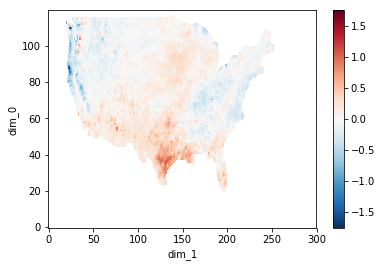

In [43]:
reg34da[:,:,7].plot()

In [44]:
print(corr34[19000,0])
print(reg34[19000,0])

0.16527405080192287
0.1007792950897908


In [45]:
print(arr_precip_norm_monthly.shape)
print(arr_precip_monthly.shape)

(120, 300, 67, 12)
(120, 300, 67, 12)


In [46]:
# try doing regression for single grid cell
#nino34_norm_m[0]
#ds_precip_norm.pn.sel(lat=34.125,lon=264.125)
#print(ds_precip_norm.pn.isel(lat=56,lon=136))
#print(np.shape(arr_precip_norm_monthly))
print(np.shape(arr_precip_norm_monthly[56,136,:,0]))
print(np.shape(nino34_norm_m[0]))
print(np.sum(nino34_norm_m[0]*arr_precip_norm_monthly[56,136,:,0])/yrmx)
print(np.matmul(nino34_norm_m[0],arr_precip_norm_monthly[56,136,:,0])/yrmx)

(67,)
(67,)
-0.014711803331052885
-0.014711803331052872


(36000, 67)
(67,)
(36000,)


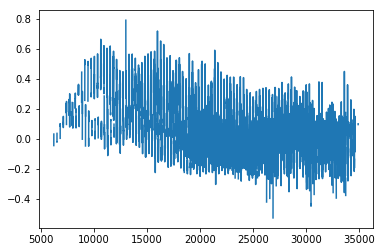

In [47]:
# try doing regression for all grid cells in single month
# works
print(np.shape(arr_pn_adj_m[:,7,:]))
print(np.shape(nino34_norm_m[7]))
test = np.matmul(arr_pn_adj_m[:,7,:],nino34_norm_m[7])/yrmx
print(np.shape(test))
plt.plot(test)

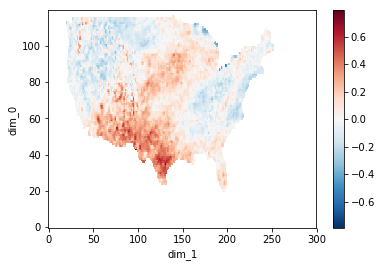

In [48]:
test = test.reshape(len(ds_precip.lat),len(ds_precip.lon))
xr.DataArray(test).plot()

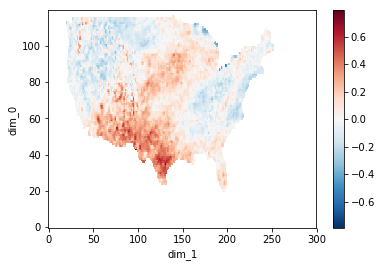

In [49]:
corr34da[:,:,7].plot()

## Maps of correlation: with wrong messed up data

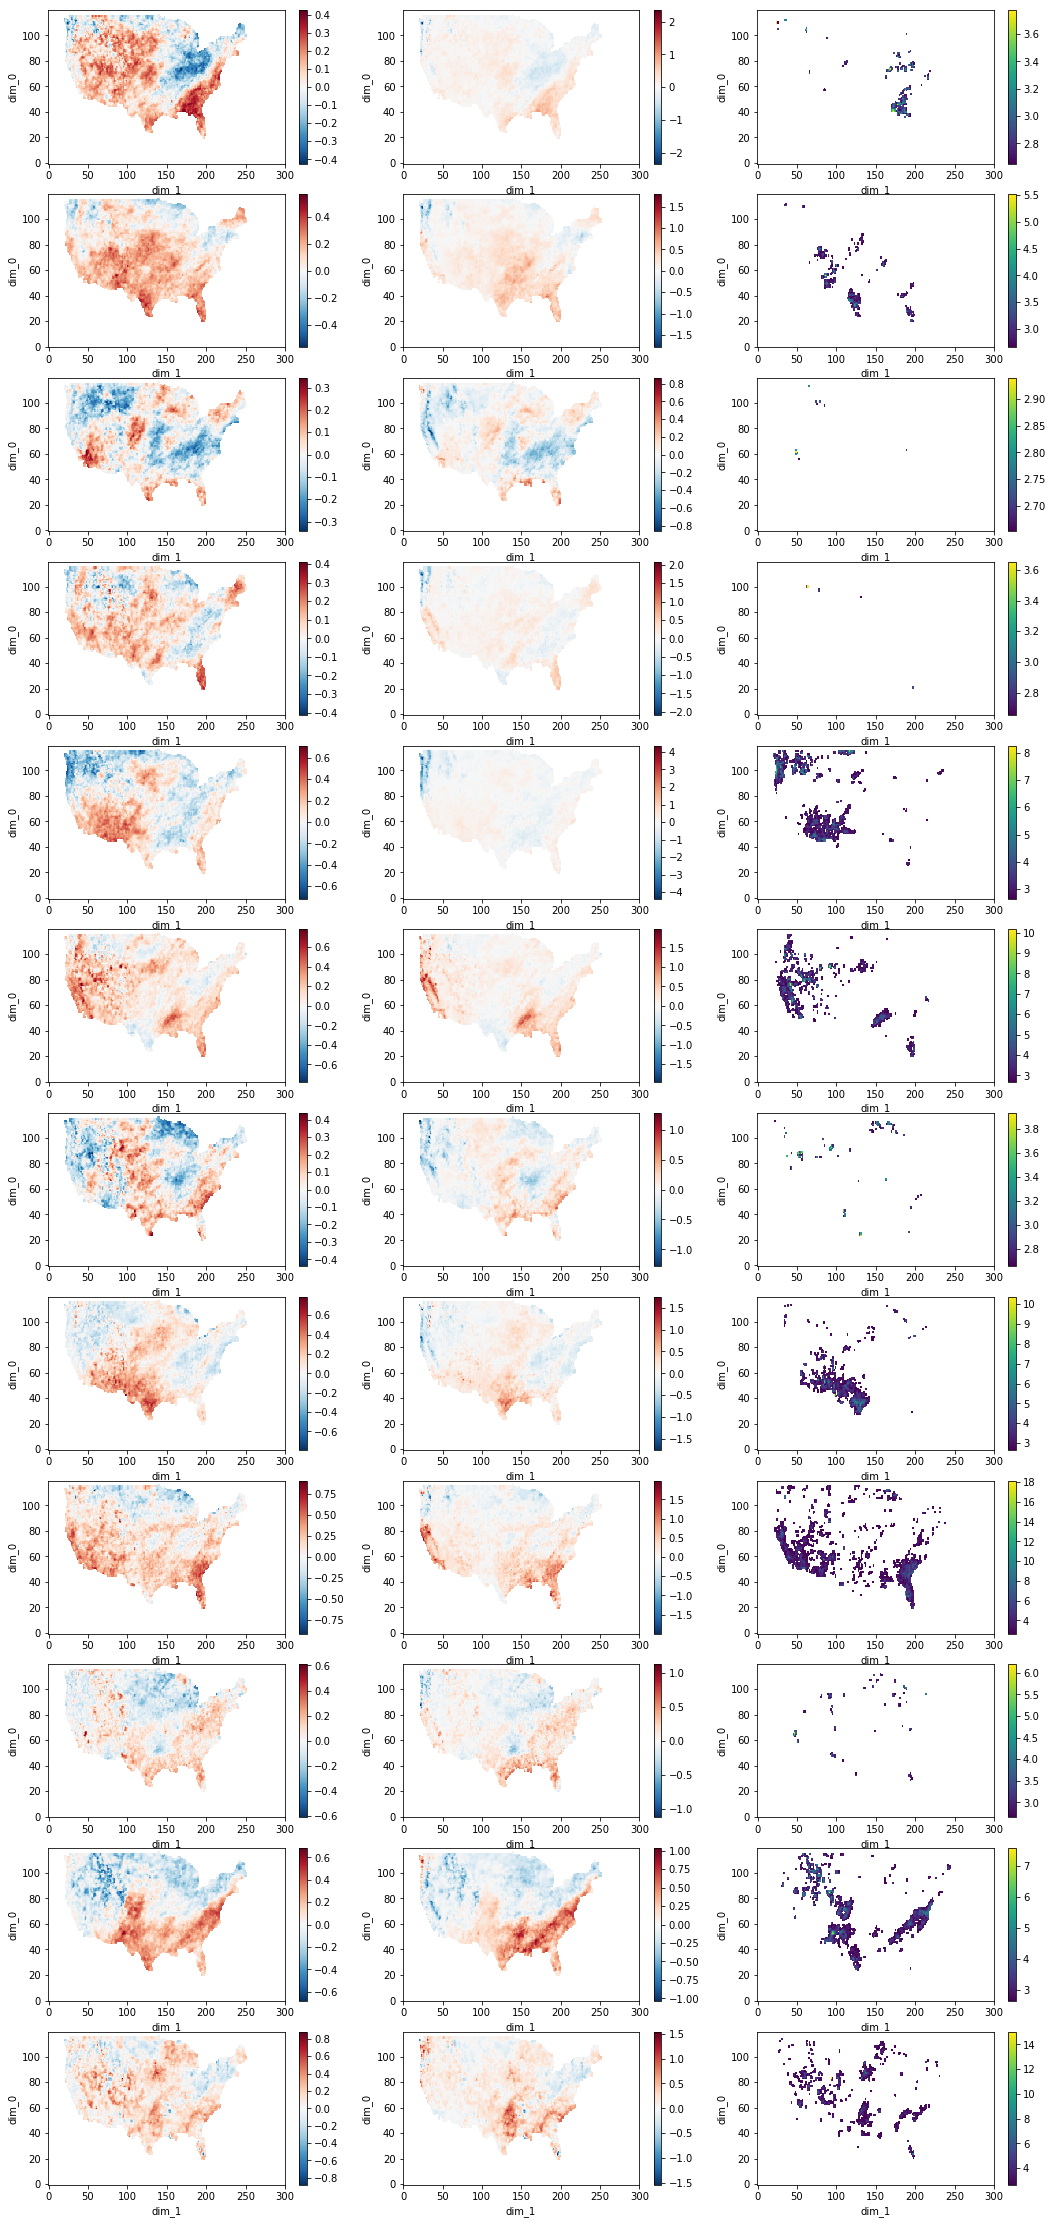

In [50]:
fig, ax = plt.subplots(nrows=12, ncols=3, figsize=(18,40))
#ax.shape
for i in range(0,12):
    corr34da[:,:,i].plot(ax=ax[i,0])
    reg34da[:,:,i].plot(ax=ax[i,1])
    tstat34sig[:,:,i].plot(ax=ax[i,2])

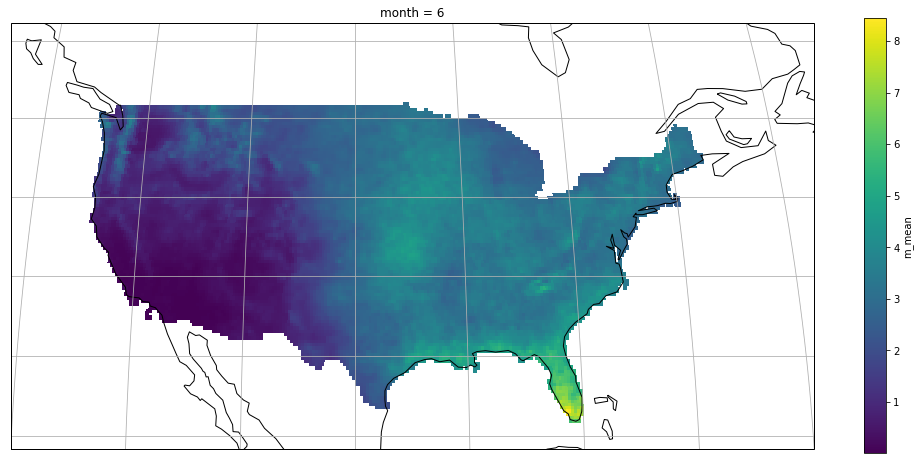

In [51]:
fig, ax = plt.subplots(figsize=(18,8))
ax = plt.axes(projection=ccrs.Robinson(260))
ax.set_extent([230,300,23,50]) # x0,x1,y0,y1
ax.coastlines()
ax.gridlines()
ds_precip_m.m_mean.isel(month=5).plot(ax=ax, transform=ccrs.PlateCarree())

## First try to replicate with scikit linreg and see whether data issue or not

In [52]:
# Using linreg from scratch; start with just jan
x = nino34_norm_m[0,:]
y = arr_pn_adj_m[:,0,:]
slope = np.zeros(len(y)*12).reshape(len(y),12)
intercept = np.zeros(len(y)*12).reshape(len(y),12)
r_value = np.zeros(len(y)*12).reshape(len(y),12)
p_value = np.zeros(len(y)*12).reshape(len(y),12)
std_err = np.zeros(len(y)*12).reshape(len(y),12)

for i,arr in enumerate(y):
    slope[i,0], intercept[i,0], r_value[i,0], p_value[i,0], std_err[i,0] = stats.linregress(x, arr)
    
    #print(i,arr)

#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#slope, intercept, r_value, p_value, std_err

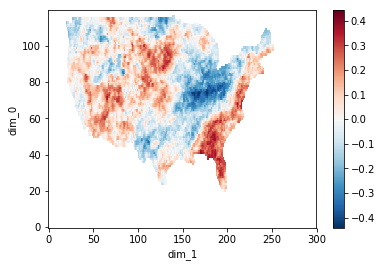

In [53]:
r_da = xr.DataArray(r_value.reshape(120,300,12))
r_da[:,:,0].plot()

In [54]:
slope.shape

(36000, 12)

## Corrected normalization, regression using for loops

In [98]:
# looping over all of the lats and lons and months

x = nino34_norm_m[:,:] # months, years
y = arr_precip_norm_monthly[:,:,:,:] # lat,lon,yrs,months -- normalized
y_precip = arr_precip_monthly[:,:,:,:] # lat,lon,yrs,months -- mean removed
slope = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*12*2).reshape(len(ds_precip.lat),len(ds_precip.lon),12,2)
intercept = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*12*2).reshape(len(ds_precip.lat),len(ds_precip.lon),12,2)
r_value = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*12*2).reshape(len(ds_precip.lat),len(ds_precip.lon),12,2)
p_value = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*12*2).reshape(len(ds_precip.lat),len(ds_precip.lon),12,2)
std_err = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*12*2).reshape(len(ds_precip.lat),len(ds_precip.lon),12,2)

for i in range(0,len(ds_precip.lat)): # loop over latitude
    for j in range(0,len(ds_precip.lon)): # loop over lon
        for m in range(0,12): # loop over months
            slope[i,j,m,0], intercept[i,j,m,0], r_value[i,j,m,0], p_value[i,j,m,0], std_err[i,j,m,0] = stats.linregress(x[m,:], y[i,j,:,m])
            slope[i,j,m,1], intercept[i,j,m,1], r_value[i,j,m,1], p_value[i,j,m,1], std_err[i,j,m,1] = stats.linregress(x[m,:], y_precip[i,j,:,m])


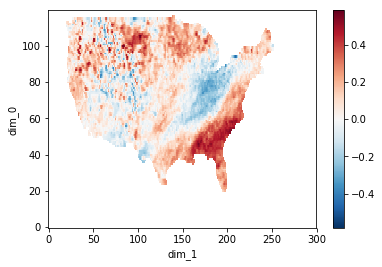

In [115]:
s_da = xr.DataArray(slope)
i_da = xr.DataArray(intercept)
r_da = xr.DataArray(r_value)
p_da = xr.DataArray(p_value)
se_da = xr.DataArray(std_err)

r_da[:,:,0,0].plot()

In [89]:
y = arr_precip_norm_monthly[:,:,:,0]
slope = np.zeros(len(ds_precip.lat)*len(ds_precip.lon)*12).reshape(len(ds_precip.lat),len(ds_precip.lon),12)
print(y.shape, slope.shape, range(0,len(ds_precip.lat)))
range(0,len(ds_precip.lat))

(120, 300, 67) (120, 300, 12) range(0, 120)


range(0, 120)

In [167]:
p_da

<xarray.DataArray (dim_0: 120, dim_1: 300, dim_2: 12, dim_3: 2)>
array([[[[nan, nan],
         ...,
         [nan, nan]],

        ...,

        [[nan, nan],
         ...,
         [nan, nan]]],


       ...,


       [[[nan, nan],
         ...,
         [nan, nan]],

        ...,

        [[nan, nan],
         ...,
         [nan, nan]]]])
Dimensions without coordinates: dim_0, dim_1, dim_2, dim_3

# Corrected Maps

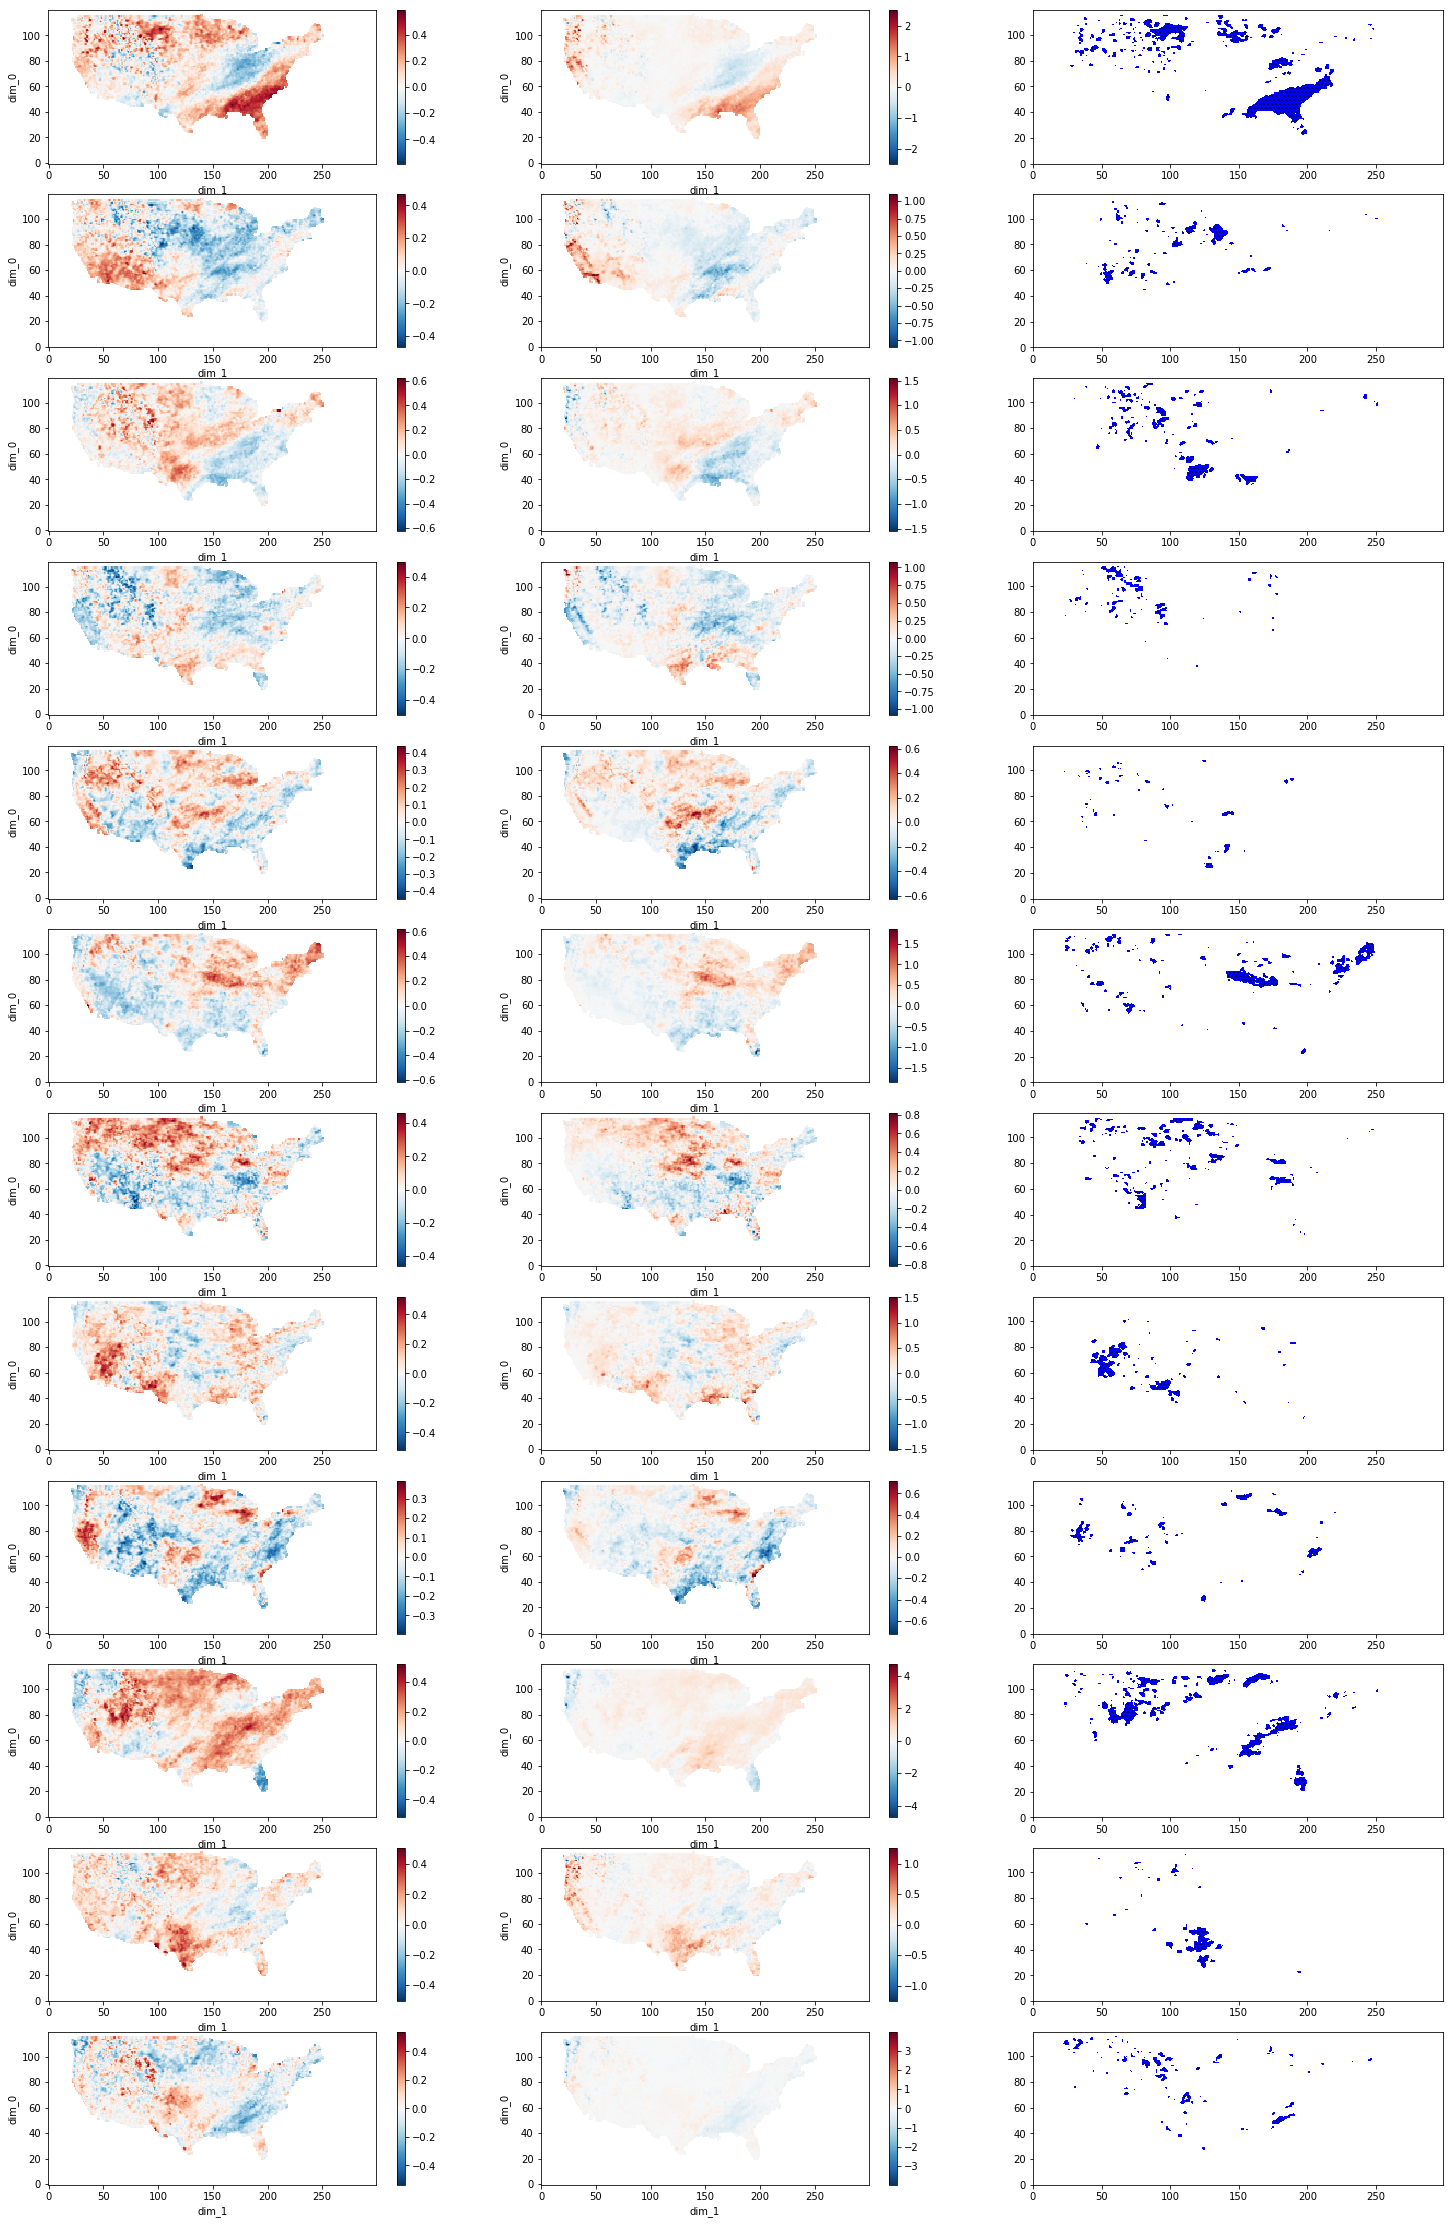

<Figure size 432x288 with 0 Axes>

In [184]:
fig, ax = plt.subplots(nrows=12, ncols=3, figsize=(25,40))

levels = [0,1-alphaupper] # contour settings for significance
colors = ['blue','white'] # contour settings for significance

for i in range(0,12):
    r_da[:,:,i,0].plot(ax=ax[i,0])
    s_da[:,:,i,1].plot(ax=ax[i,1])
    ax[i,2].contourf(p_da.dim_1,p_da.dim_0,p_da[:,:,i,0], colors=colors, levels=levels, hatches=["...","",""])
    
plt.show()
plt.tight_layout()

In [80]:
# this shows how np.reshape has somehow caused data to get warped
print(corr34[19000,0])
print(reg34[19000,0])
x=nino34_norm_m[0,:].squeeze()
y=arr_pn_adj_m[19000,0,:].squeeze()
#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#slope, intercept, r_value, p_value, std_err

0.16527405080192287
0.1007792950897908


(0.09245329064833123,
 -0.22682437364660973,
 0.09774287245164694,
 0.4313460198706568,
 0.11676053357884414)

TypeError: Input z must be a 2D array.

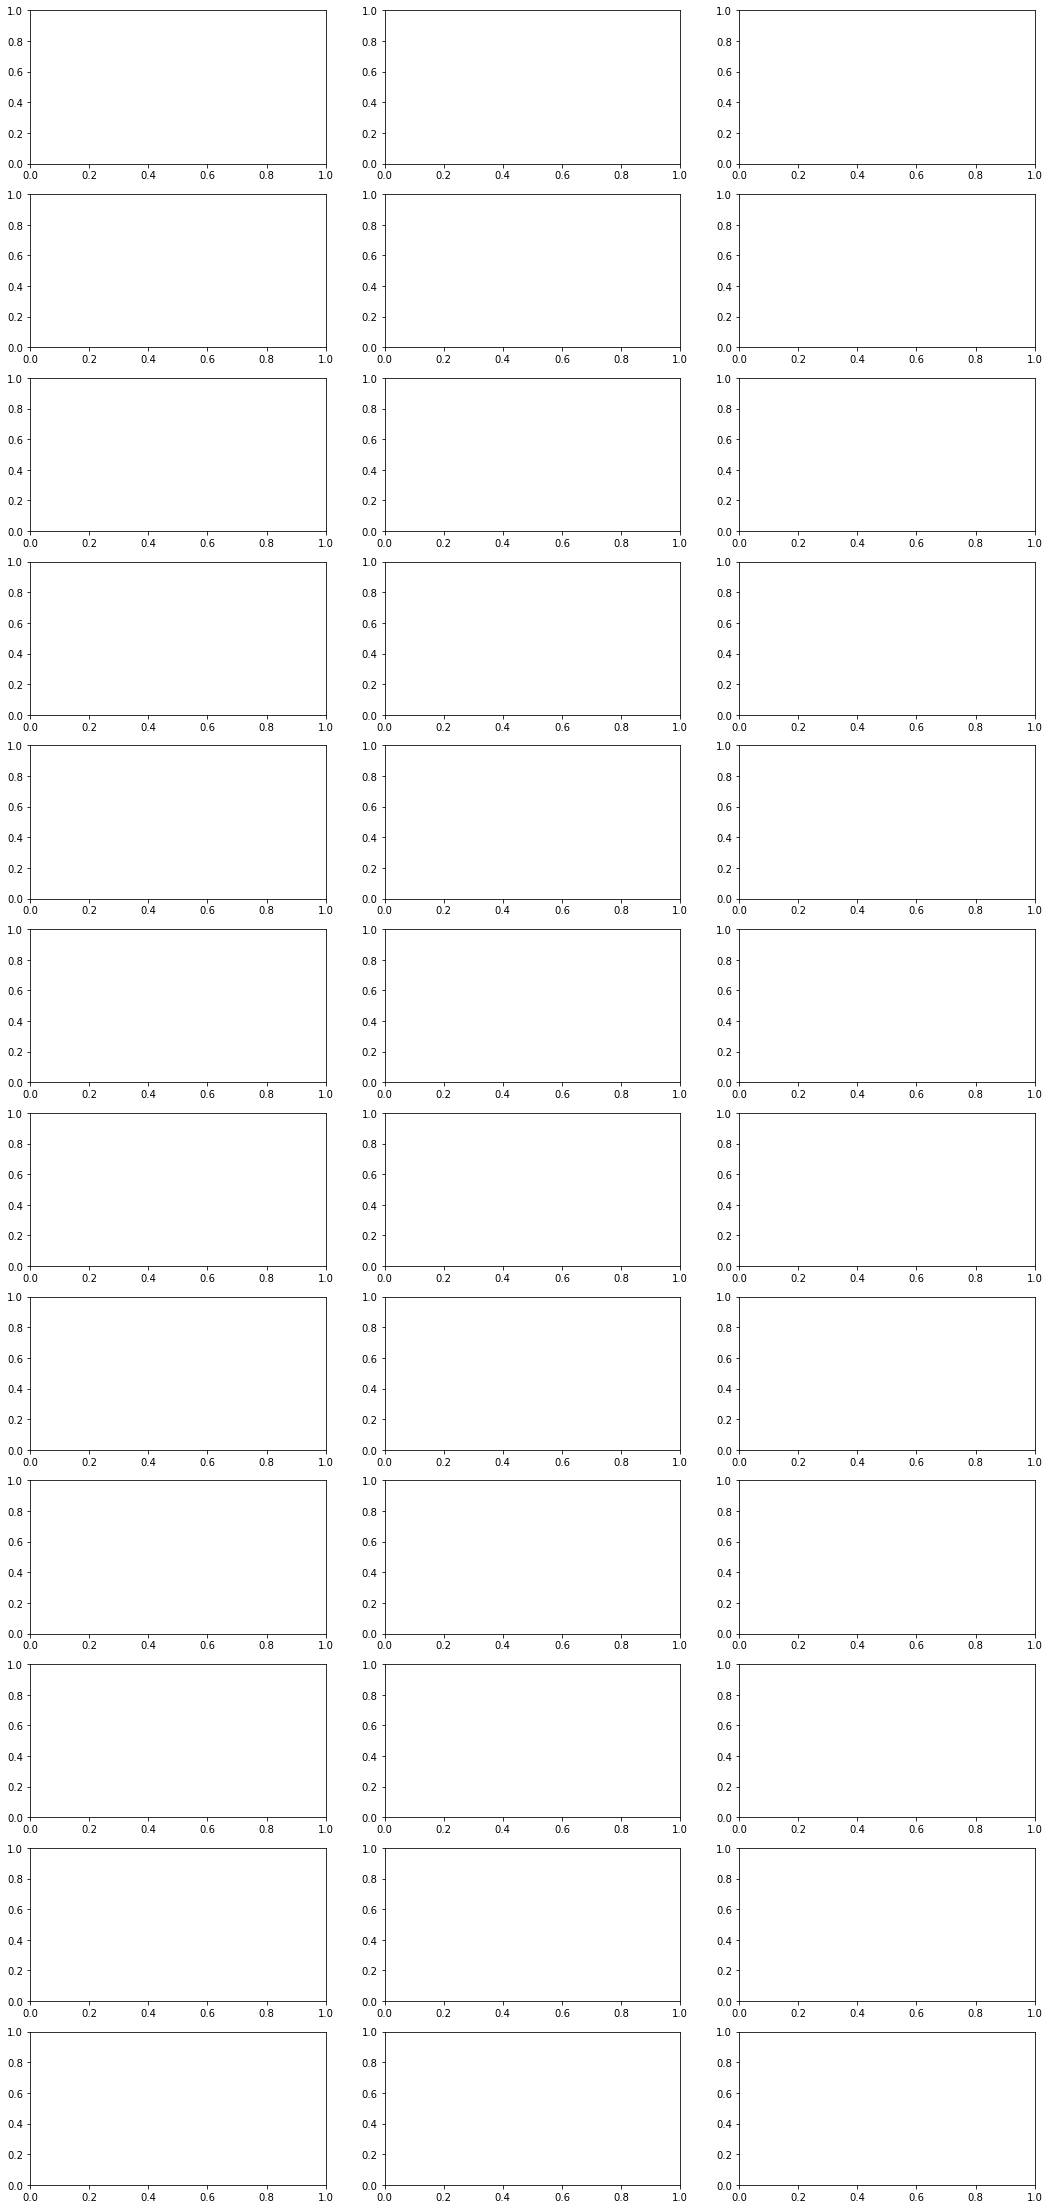

In [165]:
fig, ax = plt.subplots(nrows=12, ncols=3, figsize=(18,40))
ax[1,2].contourf(1,2,[3,4])

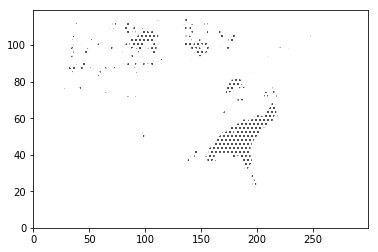

In [155]:
levels = [0,1-alphaupper]
colors = ['white','white']#],'white']
plt.contourf(p_da.dim_1,p_da.dim_0,p_da[:,:,0,0], colors=colors, levels=levels, hatches=["...","",""])